In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np
from os import listdir
import pickle
from astropy.io import fits
import pandas as pd
from PIL import Image
%matplotlib inline

In [15]:
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError

def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)

def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))

In [21]:
plt_path = "/data/renhaoye/decals_2022/code/plt/"

In [22]:
raw_fits = listdir("/data/renhaoye/decals_2022/in_decals/fits/")

In [33]:
decals_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)
sdss_df = pd.read_csv("/data/renhaoye/decals_2022/dataset_sdss_match_decals.csv", index_col=0)

decals_dataset = [decals_df.query("func == 'train'"), decals_df.query("func == 'test'"), decals_df.query("func == 'valid'")]
sdss_dataset = [sdss_df.query("func == 'train'"), sdss_df.query("func == 'test'"), sdss_df.query("func == 'valid'")]

DECaLS示例图

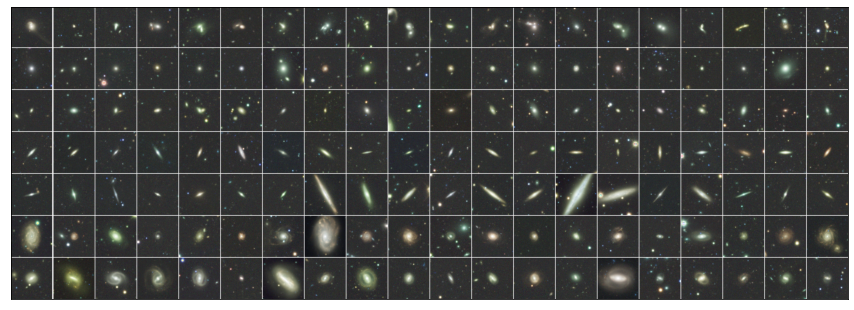

In [67]:
num = 7
col_num = 20
start_col = 190
data_dir = "/data/renhaoye/decals_2022/in_decals/decals_best/"
row_gap = np.ones((4, (col_num) * 256 + (col_num + 1 - 1) * 4, 3))
col_gap = np.ones((256, 4, 3))
row_output = None
for label in range(num):
    df = decals_dataset[0].query("label == %d" % label)
    col_output = None
    for col in range(start_col, start_col + col_num):
        ra, dec = df.iloc[col].ra, df.iloc[col].dec
        img = load_img(data_dir + str(ra) + "_" + str(dec) + ".fits")
        if (col-start_col) == 0:
            col_output = np.concatenate((chw2hwc(img), col_gap), axis=1)
        else:
            col_output = np.concatenate((col_output, col_gap, chw2hwc(img)), axis=1)
    if label == 0:
        row_output = col_output
    else:
        row_output = np.concatenate((row_output, row_gap, col_output), axis=0)
plt.figure(figsize=(15, 30))
plt.imshow(row_output)
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "DECaLS数据示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

In [86]:
import math
DEGREE = 30
PIXEL = 5
import random
random.seed(1926)
class Img:
    def __init__(self, image, rows, cols, center=None):
        self.g_dst = None
        self.r_dst = None
        self.z_dst = None
        if center is None:
            center = [0, 0]
        self.dst = None
        self.g_src = image[0]
        self.r_src = image[1]
        self.z_src = image[2]
        self.transform = None
        self.rows = rows
        self.cols = cols
        self.center = center  # rotate center

    def Shift(self, delta_x, delta_y):  # 平移
        # delta_x>0 shift left  delta_y>0 shift top
        self.transform = np.array([[1, 0, delta_x],
                                   [0, 1, delta_y],
                                   [0, 0, 1]])

    def Flip(self):  # vertically flip
        self.transform = np.array([[-1, 0, self.rows - 1],
                                   [0, 1, 0],
                                   [0, 0, 1]])

    def Rotate(self, beta):  # rotate
        # beta<0 rotate clockwise
        self.transform = np.array([[math.cos(beta), -math.sin(beta), 0],
                                   [math.sin(beta), math.cos(beta), 0],
                                   [0, 0, 1]])

    def Process(self):
        self.g_dst = np.zeros((self.rows, self.cols), dtype=np.float32)
        self.r_dst = np.zeros((self.rows, self.cols), dtype=np.float32)
        self.z_dst = np.zeros((self.rows, self.cols), dtype=np.float32)
        for i in range(self.rows):
            for j in range(self.cols):
                src_pos = np.array([i - self.center[0], j - self.center[1], 1])
                [x, y, z] = np.dot(self.transform, src_pos)
                x = int(x) + self.center[0]
                y = int(y) + self.center[1]
                if x >= self.rows or y >= self.cols:
                    self.g_dst[i][j] = 0.
                    self.r_dst[i][j] = 0.
                    self.z_dst[i][j] = 0.
                else:
                    self.g_dst[i][j] = self.g_src[int(x)][int(y)]
                    self.r_dst[i][j] = self.r_src[int(x)][int(y)]
                    self.z_dst[i][j] = self.z_src[int(x)][int(y)]
        self.dst = np.array((self.g_dst, self.r_dst, self.z_dst))
def flip(img):
    height, width = img.shape[1:3]
    output = Img(img, height, width, [0, 0])
    output.Flip()
    output.Process()
    return output.dst
def rotate(img):
    seed = random.randint(-DEGREE, DEGREE)
    height, width = img.shape[1:3]
    output = Img(img, height, width, [height / 2, width / 2])
    output.Rotate(seed)
    output.Process()
    return output.dst
def shift(img):
    height, width = img.shape[1:3]
    output = Img(img, height, width, [0, 0])
    output.Shift(PIXEL, 0)
    output.Process()
    return output.dst

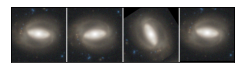

In [88]:
df = decals_dataset[0].query("label == 6")
col = 204
ra, dec = df.iloc[col].ra, df.iloc[col].dec
data_dir = "/data/renhaoye/decals_2022/in_decals/decals_best/"
img = load_img(data_dir + str(ra) + "_" + str(dec) + ".fits")
flipped = flip(img)
rotated = rotate(img)
shifted = shift(img)
col_gap = np.ones((256, 4, 3))
col_output = np.concatenate((chw2hwc(img), col_gap, chw2hwc(flipped), col_gap, chw2hwc(rotated), col_gap, chw2hwc(shifted)), axis=1)
plt.figure(figsize=(4, 10))
plt.imshow(col_output)
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "数据增强示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

SDSS示例图

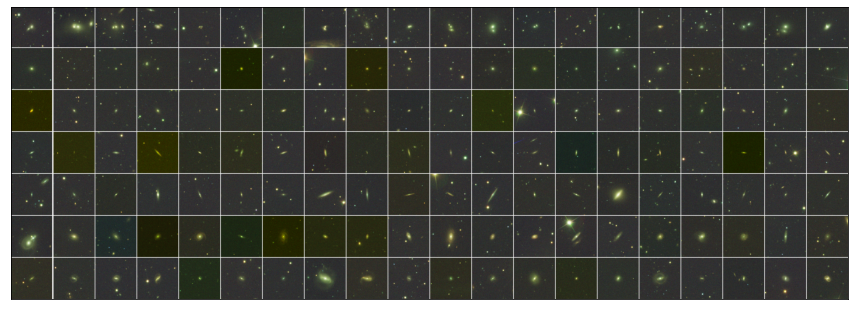

In [80]:
num = 7
col_num = 20
start_col = 190
data_dir = "/data/renhaoye/decals_2022/in_decals/sdss_agmtn_scaled/"
row_gap = np.ones((4, (col_num) * 256 + (col_num + 1 - 1) * 4, 3))
col_gap = np.ones((256, 4, 3))
row_output = None
for label in range(num):
    df = sdss_dataset[0].query("label == %d" % label)
    col_output = None
    for col in range(start_col, start_col + col_num):
        fname = df.iloc[col].sdss_loc.split("/")[-1]
        img = load_img(data_dir + fname)
        if (col-start_col) == 0:
            col_output = np.concatenate((chw2hwc(img), col_gap), axis=1)
        else:
            col_output = np.concatenate((col_output, col_gap, chw2hwc(img)), axis=1)
    if label == 0:
        row_output = col_output
    else:
        row_output = np.concatenate((row_output, row_gap, col_output), axis=0)
plt.figure(figsize=(15, 30))
plt.imshow(row_output)
plt.xticks([])
plt.yticks([])
plt.savefig(plt_path + "SDSS数据示例.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()

画波长图

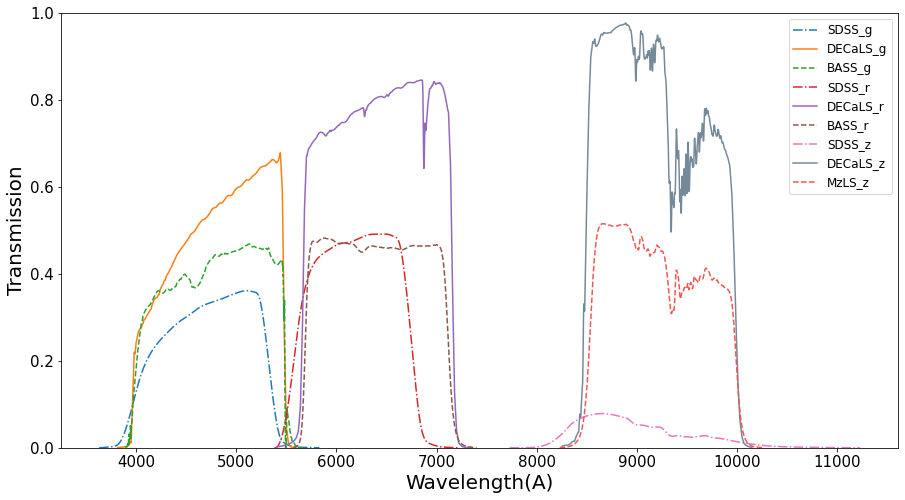

In [198]:
from scipy.interpolate import interp1d
dir = "/data/renhaoye/decals_2022/code/plt/"
def load(path):
    wavelengths = []
    throughputs = []
    with open(path, "r") as r:
        x = r.readlines()
    for i in range(len(x)):
        wavelength, throughput = x[i].split(" ")[0], x[i].split(" ")[1].split("\n")[0]
        wavelengths.append(float(wavelength))
        throughputs.append(float(throughput))
    return np.array(wavelengths), np.array(throughputs)
bass_g_w, bass_g_t = load(dir + "BOK_BASS.g.dat")
bass_r_w, bass_r_t = load(dir + "BOK_BASS.r.dat")
mzls_z_w, mzls_z_t = load(dir + "KPNO_MzLS.z.dat")
decals_g_w, decals_g_t = load(dir + "CTIO_DECam.g.dat")
decals_r_w, decals_r_t = load(dir + "CTIO_DECam.r.dat")
decals_z_w, decals_z_t = load(dir + "CTIO_DECam.z.dat")
sdss_g_w, sdss_g_t = load(dir + "SLOAN_SDSS.g.dat")
sdss_r_w, sdss_r_t = load(dir + "SLOAN_SDSS.r.dat")
sdss_z_w, sdss_z_t = load(dir + "SLOAN_SDSS.z.dat")


def fit(x, y):
    new_x = np.linspace(np.min(x), np.max(x), 1000)
    func = interp1d(x, y, kind="cubic")
    new_y = func(new_x)
    return new_x, new_y

plt.figure(figsize=(15, 8))

# g
# color = "#44cef6"
sdss_g_x, sdss_g_y = fit(sdss_g_w, sdss_g_t)
plt.plot(sdss_g_x, sdss_g_y, label="SDSS_g", linestyle='-.')

decals_g_x, decals_g_y = fit(decals_g_w, decals_g_t)
plt.plot(decals_g_x, decals_g_y, label="DECaLS_g", linestyle='-')

bass_g_x, bass_g_y = fit(bass_g_w, bass_g_t)
plt.plot(bass_g_x, bass_g_y, label="BASS_g", linestyle='--')

# r
# color = "#ff7500" # f5a31f
sdss_r_x, sdss_r_y = fit(sdss_r_w, sdss_r_t)
plt.plot(sdss_r_x, sdss_r_y, label="SDSS_r", linestyle='-.')

decals_r_x, decals_r_y = fit(decals_r_w, decals_r_t)
plt.plot(decals_r_x, decals_r_y, label="DECaLS_r", linestyle='-')

bass_r_x, bass_r_y = fit(bass_r_w, bass_r_t)
plt.plot(bass_r_x, bass_r_y, label="BASS_r", linestyle='--')

# z
# color = "#9d2933"
sdss_z_x, sdss_z_y = fit(sdss_z_w, sdss_z_t)
plt.plot(sdss_z_x, sdss_z_y, label="SDSS_z", linestyle='-.')

decals_z_x, decals_z_y = fit(decals_z_w, decals_z_t)
plt.plot(decals_z_x, decals_z_y, label="DECaLS_z", linestyle='-', color="#758a99")

mzls_z_x, mzls_z_y = fit(mzls_z_w, mzls_z_t)
plt.plot(mzls_z_x, mzls_z_y, label="MzLS_z", linestyle='--', color="#f05654")

plt.xlabel("Wavelength(A)", fontsize=20)
plt.ylabel("Transmission", fontsize=20)
plt.ylim((0., 1.))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc="best", fontsize=12)
plt.savefig(plt_path + "数据集滤光片波长透过率.png", bbox_inches="tight", pad_inches=0.0, dpi=300)
plt.show()